Mounting Google Drive

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/pytorch_tiramisu_vd') 

Dependencies

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from models import tiramisu
from datasets import camvid
from datasets import joint_transforms
import utils.imgs as img_utils
import utils.training as train_utils

CamVid

In [ ]:
# the CamVid datasaet can be found at https://github.com/alexgkendall/SegNet-Tutorial

CAMVID_PATH = ('/content/drive/MyDrive/SegNet-Tutorial/CamVid')
RESULTS_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu_vd/results103')
WEIGHTS_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu_vd/weights103')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
batch_size = 1

In [ ]:
normalize = transforms.Normalize(mean=camvid.mean, std=camvid.std)

# Train
# no fine tuning
train_joint_transformer = transforms.Compose([
    joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)

# fine tuning
train_joint_transformer_ft = transforms.Compose([
    # joint_transforms.JointRandomCrop(224), # commented for fine-tuning
    joint_transforms.JointRandomHorizontalFlip()
    ])
train_dset_ft = camvid.CamVid(CAMVID_PATH, 'train',
      joint_transform=train_joint_transformer_ft,
      transform=transforms.Compose([
          transforms.ToTensor(),
          normalize,
    ]))
train_loader_ft = torch.utils.data.DataLoader(
    train_dset_ft, batch_size=batch_size, shuffle=True)

# Validation
val_dset = camvid.CamVid(
    CAMVID_PATH, 'val', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

# Test
test_dset = camvid.CamVid(
    CAMVID_PATH, 'test', joint_transform=None,
    transform=transforms.Compose([
        transforms.ToTensor(),
        normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)


Train: 367
Val: 101
Test: 233
Classes: 12
Inputs:  torch.Size([1, 3, 224, 224])
Targets:  torch.Size([1, 224, 224])


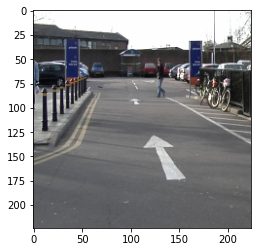

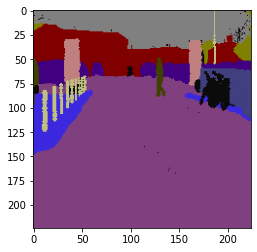

In [ ]:
print("Train: %d" %len(train_loader.dataset.imgs))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))
print("Classes: %d" % len(train_loader.dataset.classes))

inputs, targets, _ = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

img_utils.view_image(inputs[0])
img_utils.view_annotated(targets[0])

Train

In [ ]:
# Hyperparameters

LR = 1e-3
LR_FT = 1e-4
LR_DECAY = 0.995 
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 250
N_FT_EPOCHS = 50
torch.cuda.manual_seed(42)

In [ ]:
# Model and optimizer

model = tiramisu.FCDenseNet103(n_classes=12).cuda()
model.apply(train_utils.weights_init)
optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)
optimizer_ft = torch.optim.RMSprop(model.parameters(), lr=LR_FT, weight_decay=1e-4)

In [ ]:
# Uncomment this cell if you want to load weights 

train_utils.load_weights(model, '/content/drive/MyDrive/pytorch_tiramisu_vd/weights103latest.th')

loading weights '/content/drive/MyDrive/pytorch_tiramisu_vd/weights103latest.th'
loaded weights (lastEpoch 300, loss 0.3157788423618468, error 0.10189498215913773)


300

In [ ]:
# Uncomment this cell if you want to train 

# train_losses, val_losses = [], []
# train_acc, val_acc = [], []

# for epoch in range(1, N_EPOCHS + N_FT_EPOCHS + 1):
#     since = time.time()

#     ### Train ###
#     if epoch <= N_EPOCHS: ## not fine tuning
#         trn_loss, trn_err = train_utils.train(model, train_loader, optimizer, epoch)
#     else: 
#         trn_loss, trn_err = train_utils.train(model, train_loader_ft, optimizer_ft, epoch)
#     print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
#         epoch, trn_loss, 1-trn_err))    
#     time_elapsed = time.time() - since  
#     print('Train Time {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))

#     ### Test ###
#     val_loss, val_err = train_utils.test(model, val_loader, epoch)    
#     print('Val - Loss: {:.4f} | Acc: {:.4f}'.format(val_loss, 1-val_err))
#     time_elapsed = time.time() - since  
#     print('Total Time {:.0f}m {:.0f}s\n'.format(
#         time_elapsed // 60, time_elapsed % 60))
    
#     ### Plot ###
#     train_losses.append(trn_loss)
#     val_losses.append(val_loss)
#     plt.figure(figsize=(10,5))
#     plt.title("Training and Validation Loss")
#     plt.plot(val_losses,label="val")
#     plt.plot(train_losses,label="train")
#     plt.xlabel("Epochs")
#     plt.ylabel("Loss")
#     plt.legend()
#     plt.show()

#     train_acc.append(1-trn_err)
#     val_acc.append(1-val_err)
#     plt.figure(figsize=(10,5))
#     plt.title("Training and Validation Accuracy")
#     plt.plot(val_acc,label="val")
#     plt.plot(train_acc,label="train")
#     plt.xlabel("Epochs")
#     plt.ylabel("Accuracy")
#     plt.legend()
#     plt.show()

#     ### Checkpoint ###    
#     print('Saving model checkpoints', epoch)
#     print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
#     train_utils.save_weights(model, epoch, val_loss, val_err, WEIGHTS_PATH='/content/drive/MyDrive/pytorch_tiramisu_vd/weights103')

#     ### Adjust Lr ###
#     train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
#                                      epoch, DECAY_EVERY_N_EPOCHS)

Get Results

In [ ]:
# where images used to make the videos reside

VAC_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu_vd/VAC')
VAC_VIDEO_PATH.mkdir(exist_ok=True)
DISS_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu_vd/DISS')
DISS_VIDEO_PATH.mkdir(exist_ok=True)
IMG_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu_vd/IMG')
IMG_VIDEO_PATH.mkdir(exist_ok=True)
PRED_VIDEO_PATH = Path('/content/drive/MyDrive/pytorch_tiramisu_vd/PRED_VD')
PRED_VIDEO_PATH.mkdir(exist_ok=True)

In [ ]:
# test_dset
def get_results(model, test_loader):
    '''
    returns the following from a dataloader: 
    original images, NN outputs, labelled grount truth images, and image paths
    '''
    # turn off dropout layers, we're not doing monte carlo sampling
    model.eval()
    originals = []
    results = []
    targets = []
    paths = []
    with torch.no_grad():
        for data, target, path in test_loader:
            # data.shape = (1, 3, 360, 480)
            originals.append(data[0])
            data = data.to(torch.device("cuda"))
            
            # target.shape = (1, 360, 480)
            target = np.reshape(target, (172800))
            target = target.cpu().data.numpy()
            targets.append(target)
            
            # output.shape() = (1, 12, 360, 480)
            output = model(data).cpu().data.numpy()
            output = np.reshape(output, (12, 360, 480))
            results.append(output)

            # paths
            paths.append(path)
    
    return originals, results, targets, paths

def get_pixels(output):
    '''
    Reshapes the (12, 360, 480) NN output into (172800, 12) such that
    output[:, 0, 0] = reshaped_output[0]
    output[:, 0, 1] = reshaped_output[1]
    ...
    output[:, 359, 478] = reshaped_output[172798]
    output[:, 359, 479] = reshaped_output[172799]
    '''
    pixels = np.reshape(np.ravel(output), 
                        (output.shape[1] * output.shape[2], output.shape[0]), 
                        order="F")
    return pixels

def calc_vacuity(pixels):
    '''
    Calculates vacuity of an image
    '''
    # expects (172800, 12) array 
    num_classes = pixels.shape[1]
    alpha = pixels + 2.0
    S = np.sum(alpha, axis=1, keepdims=True)
    vacuity = num_classes / S
    return vacuity # (172800, 1) 

def Bal(b_i, b_j):
    result = 1 - np.abs(b_i - b_j) / (b_i + b_j + 1e-7)
    return result

def calc_dissonance(pixels):
    '''
    Calculates dissonance of an image
    '''
    # expects (172800, 12) array
    evidence = pixels + 1.0
    alpha = pixels + 2.0
    S = np.sum(alpha, axis=1, keepdims=True)
    belief = evidence / S
    dissonance = np.zeros_like(S)
    for k in range(belief.shape[0]):
        for i in range(belief.shape[1]):
            bi = belief[k][i]
            term_Bal = 0.0
            term_bj = 0.0
            for j in range(belief.shape[1]):
                if j != i:
                    bj = belief[k][j]
                    term_Bal += bj * Bal(bi, bj)
                    term_bj += bj
            dis_ki = bi * term_Bal / (term_bj + 1e-7)
            dissonance[k] += dis_ki

    return dissonance # (172800, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


IMAGE NUMBER:  0
('/content/drive/MyDrive/SegNet-Tutorial/CamVid/val/0016E5_08111.png',)
ACCURACY:  0.8855844907407407
VACUITY AUROC:  0.9270802053514505
VACUITY AUPR:  0.9901857510634406


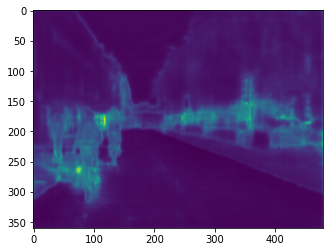

DISSONANCE AUROC:  0.9249532547098369
DISSONANCE AUPR:  0.9898632285388664


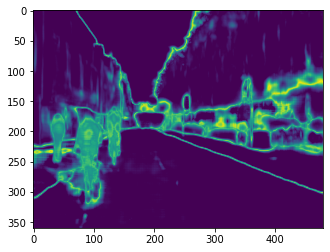

ORIGINAL IMAGES


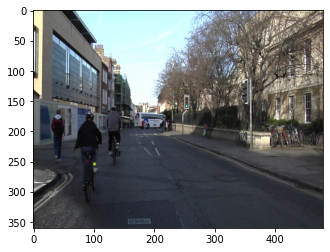

Total Time 3m 29s

~~~~~~~~~~~~~~~~~~~~~~
IMAGE NUMBER:  1
('/content/drive/MyDrive/SegNet-Tutorial/CamVid/val/0016E5_07999.png',)
ACCURACY:  0.8897511574074074
VACUITY AUROC:  0.8828193691786836
VACUITY AUPR:  0.9791882993065127


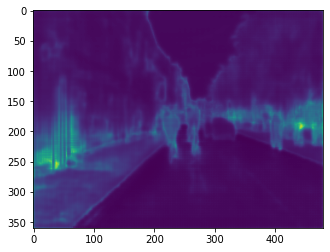

DISSONANCE AUROC:  0.905164328795024
DISSONANCE AUPR:  0.9841608353800712


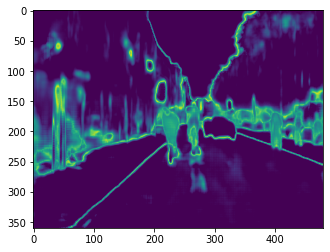

ORIGINAL IMAGES


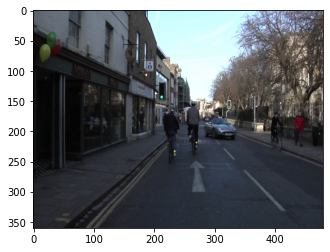

Total Time 3m 30s

~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
# NUM_IMGS = len(val_loader.dataset.imgs)
NUM_IMGS = 2

originals, res, targs, paths = get_results(model, val_loader)

overall_acc = []
overall_v_auroc = []
overall_v_aupr = []
overall_d_auroc = []
overall_d_aupr = []

from sklearn.metrics import roc_auc_score, average_precision_score
for i in range(NUM_IMGS):
    pix = get_pixels(res[i])
    
    since = time.time()
    # original shape = (12, 360, 480)
    res_reshaped = np.reshape(res[i], (res[i].shape[0], res[i].shape[1] * res[i].shape[2]))
    res_reshaped = np.argmax(res_reshaped, axis=0)
    correct_pixels = np.equal(res_reshaped, targs[i])

    print("IMAGE NUMBER: ", i)
    print(paths[i])
    
    # accuracy
    acc = np.count_nonzero(correct_pixels)/(360*480)
    overall_acc.append(acc)
    print("ACCURACY: ", acc)
    
    # vacuity
    vacuity = calc_vacuity(pix)
    v_auroc = roc_auc_score(correct_pixels, np.negative(vacuity))
    v_aupr = average_precision_score(correct_pixels, np.negative(vacuity))
    overall_v_auroc.append(v_auroc)
    overall_v_aupr.append(v_aupr)
    print("VACUITY AUROC: ", v_auroc)
    print("VACUITY AUPR: ", v_aupr)
    vacuity = np.asarray(vacuity)
    vacuity = np.reshape(vacuity, (360, 480))
    plt.imshow(vacuity)
    # plt.axis('off')
    # plt.savefig("/content/drive/MyDrive/pytorch_tiramisu_vd/VAC/vacuity" +  paths[i][0][-16:-4] + ".png", 
    #             facecolor='k', 
    #             bbox_inches='tight')
    plt.show()
    
    # dissonance
    dissonance = calc_dissonance(pix)
    d_auroc = roc_auc_score(correct_pixels, np.negative(dissonance))
    d_aupr = average_precision_score(correct_pixels, np.negative(dissonance))
    overall_d_auroc.append(d_auroc)
    overall_d_aupr.append(d_aupr)
    print("DISSONANCE AUROC: ", d_auroc)
    print("DISSONANCE AUPR: ", d_aupr)
    dissonance = np.asarray(dissonance)
    dissonance = np.reshape(dissonance, (360, 480))
    plt.imshow(dissonance)
    # plt.axis('off')
    # plt.savefig("/content/drive/MyDrive/pytorch_tiramisu_vd/DISS/dissonance" +  paths[i][0][-16:-4] + ".png", 
    #             facecolor='k', 
    #             bbox_inches='tight')
    plt.show()
    
    # original images
    print("ORIGINAL IMAGES")
    tensor = originals[i]
    img = img_utils.decode_image(tensor)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    # plt.axis('off')
    # plt.savefig("/content/drive/MyDrive/pytorch_tiramisu_vd/IMG/img" +  paths[i][0][-16:-4] + ".png", 
    #             facecolor='k', 
    #             bbox_inches='tight')
    plt.show()
    
    # time needed to process an img
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))
    print("~~~~~~~~~~~~~~~~~~~~~~")

# print model's prediction to screen and save model's prediction to a directory
def get_preds_only(model, loader):
    model.eval()
    with torch.no_grad():
        for inputs, _, path in loader:
            mc = []
            data = inputs.to(torch.device("cuda"))
            output = model(data)
            pred = train_utils.get_predictions(output)
            print(path[0][-9:-4])
            img_utils.save_annotated(
                pred[0], 
                '/content/drive/MyDrive/pytorch_tiramisu_vd/PRED_VD/prediction',
                path[0][-16:-4]
            )
    

# get_preds_only(model, val_loader)

In [ ]:
print("overall_acc =", np.mean(overall_acc))
print("overall_v_auroc =", np.mean(overall_v_auroc))
print("overall_v_aupr =", np.mean(overall_v_aupr))
print("overall_d_auroc =", np.mean(overall_d_auroc))
print("overall_d_aupr =", np.mean(overall_d_aupr))

overall_acc = 0.8876678240740741
overall_v_auroc = 0.9049497872650671
overall_v_aupr = 0.9846870251849766
overall_d_auroc = 0.9150587917524304
overall_d_aupr = 0.9870120319594688
